<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/DeepUnfoldedQFL_Agg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Quantum Federated Learning with Deep Unfolding based Weights

In this notebook provide the novel implementation of quantum federated learning which manage the client specific weights based on deep unfolding technique to enhance the benchmark federated settings and by then improve the performance of naive federated averaging. We currently, implement most widely used benchmark dataset and hope to enhance this version to implement with genomic data.

01. Module 01 - Weight calculation on NN based Deep unfolding.
02. Module 02 - Federated training process.

**Step 01: Required Dependancies**

Before execute the code, require ensure that you have the necessary libraries installed. The following commands will help you install required libraries:

The line from IPython.display import clear_output prevents dispalying unnessary output.

In [1]:
from IPython.display import clear_output
#Install required Dependencies
!pip install --upgrade seaborn
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install --upgrade pandas
!pip install --upgrade qiskit
!pip install qiskit_machine_learning

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer, execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA
import time

clear_output()

**Step 02: Load dataset, dimensionality reduction and extracting data and finalize with normalized structure.**

In [ ]:
# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

#======================================
#Loading Data
image_size = 28 # width and length are equal
data_path= "/content/drive/MyDrive/Colab Notebooks/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")


In [3]:

#Dimensionality Reduction
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [4]:
#Extracting and Normalizing Data
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])

zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n
zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)


In [ ]:
#Split data into clients in federated setting
# Assuming you have the data defined as per your initial code
train_size = 200
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A': zero_train, 'B': one_train}
test_input = {'A': zero_test, 'B': one_test}

datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

# Split data for 5 clients
num_clients = 5
client_data = {f'Client_{i+1}': {'TRAIN_DATA': [], 'TRAIN_LABELS': [], 'TEST_DATA': [], 'TEST_LABELS': []} for i in range(num_clients)}

for i in range(num_clients):
    start_idx = i * (train_size // num_clients)
    end_idx = (i + 1) * (train_size // num_clients)

    client_data[f'Client_{i+1}']['TRAIN_DATA'] = np.concatenate((zero_train[start_idx:end_idx], one_train[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TRAIN_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

    start_idx = i * (test_size // num_clients)
    end_idx = (i + 1) * (test_size // num_clients)

    client_data[f'Client_{i+1}']['TEST_DATA'] = np.concatenate((zero_test[start_idx:end_idx], one_test[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TEST_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

# Print client data
for client, data in client_data.items():
    print(f'{client}:')
    print(data)
    print()

In [6]:
from qiskit.circuit.library import ZFeatureMap, TwoLocal, RealAmplitudes

#Define Variational circuit
num_qubits = 2

# Define the feature map and variational form
FEATURE_MAP = ZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = RealAmplitudes(num_qubits, entanglement='full', reps=3)

class localOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two. evaluation
        could represent the value of the objective function
        (to be minimized or maximized) or a performance metric (to be optimized). """

        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

initial_point = np.random.random(VAR_FORM.num_parameters)

In [7]:
#Global optimizer log
class GlobalOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

global_optimizer_log = GlobalOptimizerLog()

# Initialize global model
global_model = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(callback=global_optimizer_log.update),
    initial_point=initial_point,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

<ipython-input-7-d794646cea55>:18: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  global_model = VQC(


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
# Define a function to create a deep unfolded quantum circuit
def create_deep_unfolded_circuit(feature_map, ansatz, unfolding_depth):
    deep_unfolded_circuit = qiskit.QuantumCircuit()
    for _ in range(unfolding_depth):
        deep_unfolded_circuit += feature_map
        deep_unfolded_circuit += ansatz
    return deep_unfolded_circuit
# Create a list of clients
#clients = [syft.VirtualMachine() for _ in range(num_clients)]

# Define client-specific data and deep unfolded quantum circuits
client_data = [np.random.rand(100, 3) for _ in range(num_clients)]
client_models = [create_deep_unfolded_circuit(quantum_feature_map, quantum_ansatz, unfolding_depth) for _ in range(num_clients)]

# Initialize a global model
global_model = create_deep_unfolded_circuit(quantum_feature_map, quantum_ansatz, unfolding_depth)

# Federated Learning Loop
num_iterations = 10
learning_rate = 0.01

for iteration in range(num_iterations):
    global_model_params = global_model.get_parameters()

    for i in range(num_clients):
        # Train client models on local data
        local_data = client_data[i]
        local_model = client_models[i]

        # Perform optimization on the local model with client-specific data
        # This step involves running the quantum circuit and adjusting parameters
        local_optimizer = qiskit.optimizers.COBYLA(maxiter=100)
        local_optimizer.optimize(local_model, local_data)

        # Share the updated local model parameters with the global server
        local_model_params = local_model.get_parameters()
        global_model_params += (learning_rate * (local_model_params - global_model_params))

    # Update the global model with federated averaging
    global_model.update_parameters(global_model_params)

# Evaluate the global model on a validation or test dataset
validation_data = np.random.rand(100, 3)
global_model.run(validation_data)
'''



In [8]:
#Federated Training
from qiskit.algorithms.optimizers import SLSQP
#Local Training with Global Training
import warnings
warnings.filterwarnings("ignore")
# Training settings
num_rounds = 10
learning_rate = 0.001  # Adjust as needed

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []
global_parameters=[]
global_cost=[]

# Array to store global cost
GlobalCostperRoundAll=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values
#client_weights=learnedweightsR[node][-1]



In [ ]:

trained_params_list = []
#trained_params =

#trained_params_list.append(trained_params)
initial_params = np.random.rand(VAR_FORM.num_parameters)

# Main training loop
#def train_vqc_with_deep_unfolding(num_layers, num_iterations):

    #trained_params = deep_unfolding_vqc(initial_params, num_layers, num_iterations)
    #return trained_params
params=initial_params

# Define the deep unfolding model
def deep_unfolding_vqc(params, num_layers, num_iterations):
    for layer in range(num_layers):
        # Apply one layer of the deep unfolding model
        print("Layer", layer)
        train_one_layer(params, num_iterations)

    #return params #Aggregated parameters return

# Define the training process for one layer,
#train each client's vqc model and generate global parameter and the parameters of one layer then trnafer to the next layer of deep unfols

def train_one_layer(params, num_iterations): #first give random parmeters and then every layer get aggregated parameters
    # Define  training process for one layer of the deep unfolding model

    # Train VQC for each client and obtain trained parameters
    #aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
    global_parameters = params
    #np.random.rand(VAR_FORM.num_parameters)  # need to assign previous layer's global parameters
    # Initialize with random values or any desired initial values
    aggregated_params=[]
    global_cost=[]
    client_logs=[]

    # Initialize a dictionary to store the sum of parameters for each client for all iterations
    #client_parameter_sums = {}

    # Federated training loop
    for round_num in range(num_iterations):
        aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
        #Initialize aggregated parameters to global result of previous round
        # Initialize global parameters
        print("round Number", round_num)
        # Train each client's data on their VQC models
        i=0
        i_max=num_clients
        for client_id, data in client_data.items():
          if i!=i_max+1:
            #print(client_id)
            train_data = data['TRAIN_DATA']
            train_labels = data['TRAIN_LABELS']
            test_data = data['TEST_DATA']
            test_labels = data['TEST_LABELS']
            #train_data, train_labels, test_data, test_labels= data
            # Initialize a variable to accumulate the sum of parameters for this client
            param_sum = 0

            # Set up the optimization
            Locallog = localOptimizerLog()
            optimizer = SPSA(maxiter=100, callback=Locallog.update)
            client_vqc = VQC(feature_map=FEATURE_MAP,
                  ansatz=VAR_FORM,
                  loss='cross_entropy',
                  optimizer=SPSA(callback=Locallog.update),
                  initial_point=initial_point,
                  quantum_instance=BasicAer.get_backend('qasm_simulator'))

            client_vqc.fit(train_data, train_labels)
            clients.append(client_vqc)
            client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])
        #Normalize these weights

            import tensorflow as tf
            print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")

            param_sum+=np.sum(Locallog.parameters[-1])
            # Convert the NumPy array to a TensorFlow tensor
            parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
            aggregated_params += parameters_tf
            i=i+1
            return aggregated_params

    # Calculate the sum of weighted aggregated parameters
    #aggregated_params /= sum(client_weights)

        global_parameters=aggregated_params
        print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
        # Update the global optimizer log with the aggregated parameters
        global_optimizer_log.parameters.append(global_parameters)
        global_model.fit(train_data, train_labels)
        global_cost = global_optimizer_log.costs
        print(f"Round {round_num},global cost: {global_cost}")
            # Create a list to store the last values of global_cost

        last_values = []
        filename = "Cost_DUNQFL.csv"

        # At the end of each round, save the last value of global_cost
        last_value = global_cost[-1]
        last_values.append(last_value)

        with open(filename, 'w', newline='') as csvfile:
          writer = csv.writer(csvfile)
        #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
          writer.writerow(["Last Value"])  # Write a header row
          for last_value in last_values:
            writer.writerow([last_value])


        print(f"Results saved to {filename}")

deep_unfolding_vqc(global_parameters, num_layers=1, num_iterations=5)

'''
# Apply deep unfolding to update VQC parameters
trained_params =
trained_params_list.append(trained_params)

global_parameters=trained_params
print(f"Round {round_num},global: trained_parameters = {global_parameters}")
# Update the global optimizer log with the aggregated parameters
global_optimizer_log.parameters.append(global_parameters)
'''

Step 04: Deep unfolding process to define weights

In [ ]:
################This is the latest modifying code####################
#Proxy data for layer optimization
from sklearn.model_selection import train_test_split

# Combine the data points from both classes
combined_data = np.concatenate((zero_datapoints_normalized, one_datapoints_normalized), axis=0)

# Combine the labels for both classes
combined_labels = np.concatenate((np.zeros(zero_datapoints_normalized.shape[0]), np.ones(one_datapoints_normalized.shape[0])))

# Split the combined data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)


########################################################################
#trained_params_list.append(trained_params)


# Main training loop
#def train_vqc_with_deep_unfolding(num_layers, num_iterations):

    #trained_params = deep_unfolding_vqc(initial_params, num_layers, num_iterations)
    #return trained_params
trained_params_list = []
initial_params = np.random.rand(VAR_FORM.num_parameters)
#np.zeros_like(global_parameters)  # Initialize aggregated parameters
params=initial_params
Sum_client_Para_perIteration = []

# Define the deep unfolding model
def deep_unfolding_vqc(params, num_layers, num_iterations):
    # Initialize a dictionary to store the aggregated results
    aggregated_params_perIteration = {}

    # Initialize a dictionary to store the trained parameters for each client for all iterations
    Client_Trained_Params = {}
    LayerAggregatedPara=[]
    for layer in range(num_layers):
        print("Layer number", layer)

        for iteration in range(num_iterations):
            print("Iteration number", iteration)
            Client_Trained_Params=train_one_layer(params,iteration,layer)
            print("call train one layer function for layer and received trained parameters per iteration", layer)

            #Calculate aggregate parameters at the end of each iteration,
            #and assign simple averaged aggregated parameters as the initial values for next iteration for first layer
            # Determine the number of elements in each client's list

            num_elements = len(next(iter(Client_Trained_Params.values())))
            print("Number of elements in trained parameter list", num_elements)
            # Iterate through the indices (0, 1, 2, 3, 4)
            for index in range(num_elements):
            # Initialize the sum for this index
                 index_sum = 0

                # Iterate through each client and add their value at the current index
                 for client, values in Client_Trained_Params.items():
                    index_sum += values[index]
                    index_sum=index_sum/num_clients

                # Store the sum for this index in a list {ite0:value, ite1:value....iten:value}
                 aggregated_params_perIteration[index] = index_sum

            # Initialize an empty list to store the values from the dictionary
            params_list=[]
            # Return the final aggregated parameters per iteration
            # since `aggregated_params_perIteration` dictionary
            for value in aggregated_params_perIteration.values():
                params_list = np.append(params_list,value)
            params=np.array(params_list)
            #params = aggregated_params_perIteration
            print(f"Iteration: {layer} IterAggregatedPara: {params}")
            iteration += 1

        if iteration == num_iterations: #at the final iteration in one layer
            LayerAggregatedPara=params
            print(f"Layer: {layer} LayerAggregatedPara: {LayerAggregatedPara}")

        #use thses layer parameter to train proxy data in global model prototype and optimize the vqc parameters
        #Then assign optimized parmetrs to params to work with next deep unfolding layer.
        global_parameters=LayerAggregatedPara
        # Initialize global model
        global_model = VQC(
           feature_map=FEATURE_MAP,
           ansatz=VAR_FORM,
           loss='cross_entropy',
           optimizer=SPSA(callback=global_optimizer_log.update),
           initial_point=global_parameters,
           quantum_instance=BasicAer.get_backend('qasm_simulator')
          )
        global_model.fit(X_train, y_train)
        global_paralayer= global_optimizer_log.parameters
        print(f"Layer {layer},global parameter: {global_paralayer}")
        params=global_paralayer

        #Final process to clauclate client weights after unfolding process.
        if layer == num_layers:
          # Initialize a list to store the sum of parameters for each client
          clients_sums = []
          clients_weights=[]

          # Iterate through the clients and calculate the sum of parameters for each client
          for client, parameters in Client_Trained_Params.items():
              sum_of_parameters = sum(parameters)
              clients_sums = sum_of_parameters

          # Print the sum of parameters for each client
          for client, sum_of_parameters in zip(Client_Trained_Params.keys(), clients_sums):
              print(f"{client}: Sum of Parameters = {sum_of_parameters}")
              clients_weights.append(sum_of_parameters/sum(clients_sums))

          # Print the weights for each client
          print("Client weihts after deep unfolding process",clients_weights)
          #for client, weight in zip(clients_weights):
              #print(f"{client}: Weight = {weight}")


          # The clients_sums list contains the sums of parameters for each client
          #print("Sums of Parameters for All Clients:", clients_sums)
    return clients_weights

    # Return the final parameters
    #return Client_Trained_Params

    #return params #Aggregated parameters return


# Define the training process for one layer,
#train each client's vqc model and generate global parameter and the parameters of one layer then trnafer to the next layer of deep unfols
def train_one_layer(params,iteration,layer):

    #first give random parmeters and then every layer assign params as aggregated parameters #(#initial_params = np.random.rand(VAR_FORM.num_parameters), params=initial_params)
    aggregated_params = params

    # need to assign previous layer's global parameters

    global_cost=[]
    client_logs=[]

    # Initialize a dictionary to store the trained parameters for each client for all iterations
    Client_Trained_Params = {} #(client0:[], client1:[]...)

    # Federated training loop

    # Train each client's data on their VQC models
    #print("federaed trainning start")
    i=0
    i_max=num_clients
    #print("done2",client_data.items())
    for client_id, data in client_data.items():
      #print("done3")
      #if i!=i_max+1:
            #print(client_id)
      output_list = []  # To store model predictions
      target_list = []  # To store target values
      param_sum = 0

      train_data = data['TRAIN_DATA']
      train_labels = data['TRAIN_LABELS']
      test_data = data['TEST_DATA']
      test_labels = data['TEST_LABELS']

      # Set up the optimization
      Locallog = localOptimizerLog()
      optimizer = SPSA(maxiter=100, callback=Locallog.update)
      client_vqc = VQC(feature_map=FEATURE_MAP,
            ansatz=VAR_FORM,
            loss='cross_entropy',
            optimizer=SPSA(callback=Locallog.update),
            initial_point=params,
            quantum_instance=BasicAer.get_backend('qasm_simulator'))

      client_vqc.fit(train_data, train_labels)
      clients.append(client_vqc)
      client_logs.append(Locallog)

      # After training, get the model's predictions on a validation set (test_data)
      predictions = client_vqc.predict(test_data)
      output_list.append(predictions)
      target_list.append(test_labels)

      import tensorflow as tf
      #print(f"Round {iteration}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
      print(f"Client {client_id}: parameters = {Locallog.parameters[-1]}")
      parameters=Locallog.parameters[-1]
      #save all sum of parameters into a dictionary and get noramlized sum of weights

      # Convert the NumPy array to a TensorFlow tensor
      #parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)
      # Append the parameter data to the dictionary
      Client_Trained_Params[client_id] = parameters
      #aggregated_params += parameters

      #i=i+1
    return Client_Trained_Params

DUNclient_weights=[]
DUNclient_weights=deep_unfolding_vqc(params, num_layers=2, num_iterations=2)
federated_training(100,DUNclient_weights,"origin")



Layer number 0
Iteration number 0
Client Client_1: parameters = [ 0.70240055 -1.05382142  0.77379375  0.34514115 -0.34469393  0.56353171
  1.8775824   1.99467534]
Client Client_2: parameters = [ 1.29018301  0.67799568 -0.24702697 -0.11595956  1.35495231 -0.27163683
  0.59595867  1.21040985]
Client Client_3: parameters = [ 2.13855549 -0.47568943  2.02718159  3.15874921  1.10269465 -1.44438176
 -0.41714362  1.67244737]
Client Client_4: parameters = [ 1.20676955  0.40441808  0.88588582  0.27832984 -0.52001236 -0.34446551
  1.4365576   0.68135058]
Client Client_5: parameters = [ 1.38387551 -0.01868705  1.02818321  0.33572248  0.13273261 -0.04250996
  0.41733108  0.89462469]
call train one layer function for layer and received trained parameters per iteration 0
Number of elements in trained parameter list 8
Iteration: 0 IterAggregatedPara: [ 0.34444339  0.00938137  0.2571419   0.10347259  0.01662521 -0.03408995
  0.13914573  0.22213349]
Iteration number 1
Client Client_1: parameters = [ 2.1

##Federated training

In [ ]:
def federated_training(num_iterations, client_weights, option):
    aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
  # Federtaed training loop
    for round_num in range(num_iterations):

        #Initialize aggregated parameters to global result of previous round
        # Initialize global parameters
        print("round Number", round_num)
        # Train each client's data on their VQC models
        i=0
        i_max=num_clients
        for client_id, data in client_data.items():
          if i!=i_max+1:
            #print(client_id)
            train_data = data['TRAIN_DATA']
            train_labels = data['TRAIN_LABELS']
            test_data = data['TEST_DATA']
            test_labels = data['TEST_LABELS']
            #train_data, train_labels, test_data, test_labels= data
            # Initialize a variable to accumulate the sum of parameters for this client
            param_sum = 0

            # Set up the optimization
            Locallog = localOptimizerLog()
            optimizer = SPSA(maxiter=100, callback=Locallog.update)
            client_vqc = VQC(feature_map=FEATURE_MAP,
                  ansatz=VAR_FORM,
                  loss='cross_entropy',
                  optimizer=SPSA(callback=Locallog.update),
                  initial_point=aggregated_params,
                  quantum_instance=BasicAer.get_backend('qasm_simulator'))

            client_vqc.fit(train_data, train_labels)
            clients.append(client_vqc)
            client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])
        #Normalize these weights

            import tensorflow as tf
            print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")

            param_sum+=np.sum(Locallog.parameters[-1])
            # Convert the NumPy array to a TensorFlow tensor
            parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
            if option == "origin":
              aggregated_params += parameters_tf
              i=i+1
              return aggregated_params
            if option == "DUN"
              weighted_params = parameters_tf * client_weights[i]
              aggregated_params=weighted_params
              i=i+1
              return aggregated_params

    # Calculate the sum of weighted aggregated parameters
    #aggregated_params /= sum(client_weights)

        global_parameters=aggregated_params
        print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
        # Update the global optimizer log with the aggregated parameters
        global_optimizer_log.parameters.append(global_parameters)
        global_model.fit(train_data, train_labels)
        global_cost = global_optimizer_log.costs
        print(f"Round {round_num},global cost: {global_cost}")
        print(f"Accuracy: {global_model.score(test_data, test_labels)}")
        # Create a list to store the last values of global_cost


        last_values = []
        filename = "Cost_DUNQFL.csv"

        # At the end of each round, save the last value of global_cost
        last_value = global_cost[-1]
        last_values.append(last_value)

        with open(filename, 'w', newline='') as csvfile:
          writer = csv.writer(csvfile)
        #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
          writer.writerow(["Last Value"])  # Write a header row
          for last_value in last_values:
            writer.writerow([last_value])


        print(f"Results saved to {filename}")


In [ ]:

'''


        global_parameters=aggregated_params
print(f"Round {iteration},global: aggregated_parameters = {global_parameters}")
        # Update the global optimizer log with the aggregated parameters
global_optimizer_log.parameters.append(global_parameters)
global_model.fit(train_data, train_labels)
global_cost = global_optimizer_log.costs
print(f"Round {iteration},global cost: {global_cost}")
# Create a list to store the last values of global_cost

last_values = []
filename = "Cost_DUNQFL.csv"

# At the end of each round, save the last value of global_cost
last_value = global_cost[-1]
last_values.append(last_value)

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
    writer.writerow(["Last Value"])  # Write a header row
    for last_value in last_values:
      writer.writerow([last_value])


print(f"Results saved to {filename}")


# Apply deep unfolding to update VQC parameters
trained_params =
trained_params_list.append(trained_params)

global_parameters=trained_params
print(f"Round {round_num},global: trained_parameters = {global_parameters}")
# Update the global optimizer log with the aggregated parameters
global_optimizer_log.parameters.append(global_parameters)

'''

In [ ]:
import numpy as np
#from qiskit.aqua.components.optimizers import SPSA
#from qiskit.aqua.algorithms import VQC
#from qiskit.providers.aer import AerSimulator
#from qiskit.aqua import QuantumInstance
from qiskit import BasicAer

# Define your quantum circuit
def create_quantum_circuit(params):
    # Define your quantum circuit here
    n_qubits = 4  # Adjust based on your circuit
    qc = QuantumCircuit(n_qubits)

    # Apply quantum gates based on the parameters
    for i in range(n_qubits):
        qc.rx(params[i], i)

    return qc

# Define a function to evaluate the quantum circuit
def evaluate_quantum_circuit(params):
    # Create the quantum circuit
    qc = create_quantum_circuit(params)

    # Simulate the circuit
    simulator = AerSimulator()
    quantum_instance = QuantumInstance(simulator, shots=1024)  # Adjust shots as needed
    vqc = VQC(feature_map=FEATURE_MAP, ansatz=VAR_FORM, loss='cross_entropy',
              optimizer=SPSA(callback=Locallog.update), initial_point=params,
              quantum_instance=quantum_instance)
    vqc_circuit = vqc.construct_circuit(params)
    job = quantum_instance.execute(vqc_circuit)
    result = job.result()

    # Extract the output state vector or other relevant information
    statevector = result.get_statevector()

    return statevector

# Define the deep unfolding model
def deep_unfolding_vqc(params, num_layers):
    for layer in range(num_layers):
        # Apply one layer of the deep unfolding model
        params = train_one_layer(params)
    return params

# Define the training process for one layer
def train_one_layer(params):
    # Define your training process for one layer of the deep unfolding model
    # This could involve gradient descent or other optimization techniques
    optimizer = SPSA()
    # Modify this part to optimize the quantum circuit's parameters
    params, _ = optimizer.optimize(num_vars=len(params), objective_function=lambda x: loss_function(x))
    return params

# Define a loss function
def loss_function(params):
    # Define your loss function based on the task
    # You may need to compare the output of the quantum circuit with ground truth
    target_state = np.array([0.0, 1.0, 0.0, 0.0])
    quantum_state = evaluate_quantum_circuit(params)
    return np.linalg.norm(quantum_state - target_state)  # Example loss

# Main training loop for one client
def train_vqc_with_deep_unfolding(num_layers, num_iterations):
    initial_params = np.random.rand(4)
    trained_params = deep_unfolding_vqc(initial_params, num_layers)
    return trained_params

# List of clients (each client has its own data)
#client_data_list = client_data.items

# Train VQC and apply deep unfolding for each client
trained_params_list = []

for client_data in client_data.items():
    # Train a VQC for the client
    # Set up the optimization
    Locallog = localOptimizerLog()
    vqc = VQC(feature_map=FEATURE_MAP, ansatz=VAR_FORM, loss='cross_entropy',
              optimizer=SPSA(callback=Locallog.update), initial_point=None,
              quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqc.fit(train_data, train_labels)

    # Apply deep unfolding to update VQC parameters
    trained_params = train_vqc_with_deep_unfolding(num_layers=4, num_iterations=10)
    trained_params_list.append(trained_params)

# Print the trained parameters for each client
for client_id, trained_params in enumerate(trained_params_list):
    print(f"Client {client_id + 1} Trained Parameters:", trained_params)


AttributeError: ignored

In [ ]:
#Weighted FL
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]

    #Initialize aggregated parameters to global result of previous round

    # Train each client's data on their VQC models
    i=0
    i_max=num_clients
    for client_id, data in client_data.items():
       if i!=i_max+1:
        #print(client_id)
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization

        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        # clear objective value history
        objective_func_vals = []

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])

        #Normalize these weights


        import tensorflow as tf
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        # Convert the NumPy array to a TensorFlow tensor
        parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
        weighted_parameters = parameters_tf
        aggregated_params += weighted_parameters
        i=i+1


    # Calculate the sum of weighted aggregated parameters
    #aggregated_params /= sum(client_weights)

    global_parameters=aggregated_params
    print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num},global cost: {global_cost}")


    # Save results to a CSV file

    # Create a list to store the last values of global_cost
    last_values = []
    filename = "Cost_DUNQFL.csv"

    # At the end of each round, save the last value of global_cost
    last_value = global_cost[-1]
    last_values.append(last_value)

with open(filename, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow([last_value])


print(f"Results saved to {filename}")
    #global_parameters=global_optimizer_log.parameters[-1]
#print(global_parameters)
#Aggregate client parameters




AttributeError: ignored

In [ ]:
#Weighted FL
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#%% Definition of Unfolded FL
class TrainDUW(nn.Module):
    def __init__(self) -> None:
        super(TrainDUW, self).__init__()
        #self.thetak = nn.ParameterList([nn.Parameter(torch.ones(T)*np.sqrt(len(train_datasets[i])/N)) for i in range(K)])
        # initial value: N_k/N
    def network(self, W1, b1, W2, b2, W3, b3, x):
        x = torch.relu(torch.matmul(x,W1.T)+b1.T)
        x = torch.relu(torch.matmul(x,W2.T)+b2.T)
        x = F.log_softmax(torch.matmul(x,W3.T)+b3.T, dim=1)
        return x

    def forward(self, aveW1, aveb1, aveW2, aveb2, aveW3, aveb3):
        aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

        # Federated training loop
        for round_num in range(num_rounds):
            global_cost=[]
            client_logs=[]

            aggregated_params = global_parameters.copy()
            i=0
            i_max=num_clients
            for client_id, data in client_data.items():
              if i!=i_max+1:
                train_data = data['TRAIN_DATA']
                train_labels = data['TRAIN_LABELS']
                test_data = data['TEST_DATA']
                test_labels = data['TEST_LABELS']

                Locallog = localOptimizerLog()
                optimizer = SPSA(maxiter=100, callback=Locallog.update)
                vqc = VQC(feature_map=FEATURE_MAP,
                ansatz=VAR_FORM,
                loss='cross_entropy',
                optimizer=SPSA(callback=Locallog.update),
                initial_point=global_parameters,
                quantum_instance=BasicAer.get_backend('qasm_simulator'))
                vqc.fit(train_data, train_labels)
                clients.append(vqc)
                client_logs.append(Locallog)
                import tensorflow as tf
                print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")

                parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)
                weighted_parameters = parameters_tf
                aggregated_params += weighted_parameters
                i=i+1

            global_parameters=aggregated_params
            print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")

            global_optimizer_log.parameters.append(global_parameters)
            global_model.fit(train_data, train_labels)
            global_cost = global_optimizer_log.costs
            print(f"Round {round_num},global cost: {global_cost}")


In [ ]:
        #each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs[-100:], label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitDUN-QFL Cost Evolution for Optimization-Mnist Data')
plt.legend()
plt.show()

In [ ]:
filename2="DUNcost_globallast Round.csv"
with open(filename2, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow(global_optimizer_log.costs[-100:])


print(f"Results saved to {filename2}")

Results saved to DUNcost_globallast Round.csv


In [ ]:
#Weighted FL
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]

    #Initialize aggregated parameters to global result of previous round

    # Train each client's data on their VQC models
    i=0
    i_max=num_clients
    for client_id, data in client_data.items():
       if i!=i_max+1:
        #print(client_id)
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization

        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])

        #Normalize these weights


        import tensorflow as tf
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        # Convert the NumPy array to a TensorFlow tensor
        parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
        weighted_parameters = parameters_tf * client_weights[i]
        aggregated_params += weighted_parameters
        i=i+1


    # Calculate the sum of weighted aggregated parameters
    aggregated_params /= sum(client_weights)

    global_parameters=aggregated_params
    print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num},global cost: {global_cost}")


      # Save results to a CSV file

    # Create a list to store the last values of global_cost
    last_values = []
    filename = "Cost_DUNQFL.csv"

     # At the end of each round, save the last value of global_cost
    last_value = global_cost[-1]
    last_values.append(last_value)

with open(filename, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow([last_value])


print(f"Results saved to {filename}")
    #global_parameters=global_optimizer_log.parameters[-1]
#print(global_parameters)
#Aggregate client parameters




## Result Visualization

In [ ]:
filename2="cost_globallast Round.csv"
with open(filename2, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow(global_optimizer_log.costs[-100:])


print(f"Results saved to {filename2}")

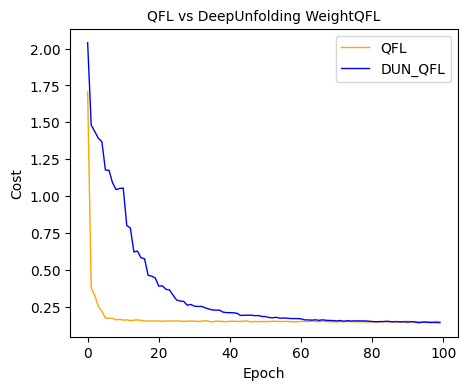

In [ ]:
import csv
import matplotlib.pyplot as plt
# Read data from the CSV file and append it to the list
fileName1="/content/drive/MyDrive/Colab Notebooks/QFL/cost_globallast Round.csv"
qfl=[]
dunqfl=[]
try:
    with open(fileName1, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            dunqfl.append((float(row[1])))
            qfl.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{fileName1}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = 100
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), qfl, label="QFL", linewidth=1,color='orange')#LR=0.01, maxiter=100
plt.plot(range(epoch), dunqfl, label="DUN_QFL", linewidth=1,color='blue')#LR=0.01, maxiter=100

plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QFL vs DeepUnfolding WeightQFL', fontsize=10)
plt.legend()
plt.show()